#Drive bağlantısını sağlama ve dosyaya erişim.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

#Gerekli Kütüphanelerin Eklenmesi

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

#GPU Kontrolü

In [ ]:
'''%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))'''

In [ ]:
'''print(tf.__version__)
print(tf.test.gpu_device_name()) #gpu kontrolü'''

#Veri Setine Erişim

In [ ]:
!ls

In [ ]:
os.chdir('/gdrive/My Drive/TurkSofrasi')

In [ ]:
!ls

In [ ]:
!ls Turk-15/

In [ ]:
os.listdir('Turk-15')

#Rastgele Değerlerin Ekrana Basılması

In [ ]:
rows = 6
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(10,10))
fig.suptitle("Her sınıftan rastgele seçilen örnekler", y=1.05, fontsize=24) 
data_dir = "Turk-15/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    if food_selected == 'denemeturk-15.py':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) 
    food_selected_random = np.random.choice(food_selected_images) 
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [ ]:
del foods_sorted[0]

In [ ]:
foods_sorted

#Model Eğitimi

##Bazı Hiper Parametrelerin Belirlenmesi

In [ ]:
batch_size = 128           #Modelin aynı anda kaç veri işleyeceğini seçer
img_height = 224           #Resmi yeniden boyutlandırmak için değer seçme, resmin uzunluğu
img_width = 224            #Resmin genişliği

##Eğitim ve Validasyon Verilerinin Ayrılması

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/gdrive/My Drive/TurkSofrasi/Turk-15",
  validation_split=0.2,                                             #Veri kümesinin %80'i eğitimde kullanıldı
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
 "/gdrive/My Drive/TurkSofrasi/Turk-15",
  validation_split=0.2,                                            #Veri kümesinin %20'si validasyon için kullanıldı
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

##Rastgele Örnek Seçilmesi.

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Kullanılan Shapelerin Görüntülenmesi

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

##Normalizasyon Katmanı

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)                  #Görüntüleri yeniden ölçeklendirme.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


print(np.min(first_image), np.max(first_image))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE                   #Çalışma zamanında değeri ototmatik olarak geliştirmek için eklendi.

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Sinir Ağının Oluşturulması ve Görüntülenmesi

In [ ]:
from tensorflow.keras import layers                          #modal.add'de kullanılabilirdi.

In [ ]:
num_classes = len(class_names)

##Data Augmentation (Veri Artırma) ve Dropout İşleminin Uygulanması

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  #1. Katman
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),

  #2. Katman
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),

  #3. Katman
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),

  #4. Katman
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  #layers.MaxPooling2D(),
  
  #5. Katman
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),

  #6. Katman
  layers.Flatten(),
  layers.Dense(17, activation='softmax'), 
  layers.Dense(num_classes)
])


#BatchNormalization işlemi yaptığım testlerden sonra yorum satırına alındı. Loss'u ciddi ölçüde dalgalandırıyordu.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
epochs = 224
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#karmaşıklık matrisini f1 score ekle 

In [ ]:
model.save('new_model_height224x.h5')

In [ ]:
from keras.models import load_model
new_model = load_model('new_model_height224x.h5')

In [ ]:
new_model.summary()

In [ ]:
new_model.get_weights()

In [ ]:
new_model.optimizer

In [ ]:
print(class_names)

In [ ]:
from keras.preprocessing.image import load_img

image = load_img('/gdrive/My Drive/TurkSofrasi/test_img/adana-kebap.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = new_model.predict(img)
print("Predicted Class: ", label)


In [ ]:
image = load_img('/gdrive/My Drive/TurkSofrasi/test_img/baklava.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = new_model.predict(img)
print("Predicted Class: ", label)

#Deneysel Sonuçlar



##Örnek-1
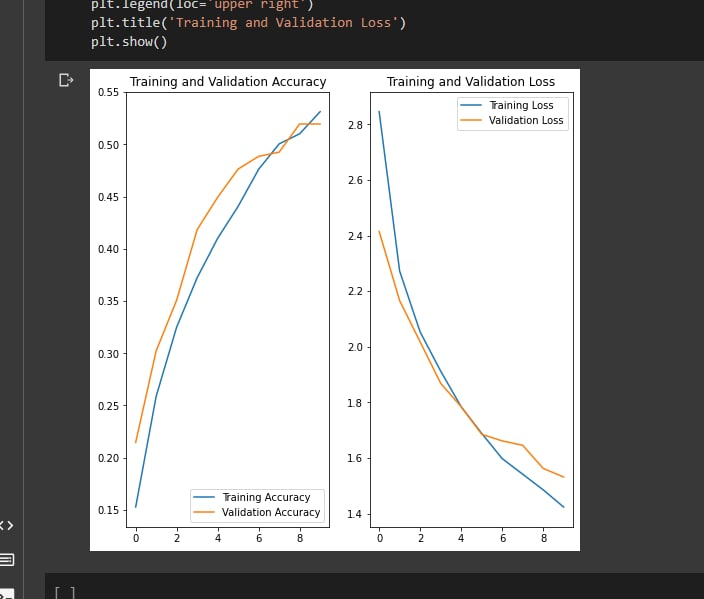


Bu örnekte sinir ağında accuracy score nispeten düşük olmasına rağmen loss değeri oldukça düşüktür istenilen öğrenim şekline çok yakındır.

##Örnek-2

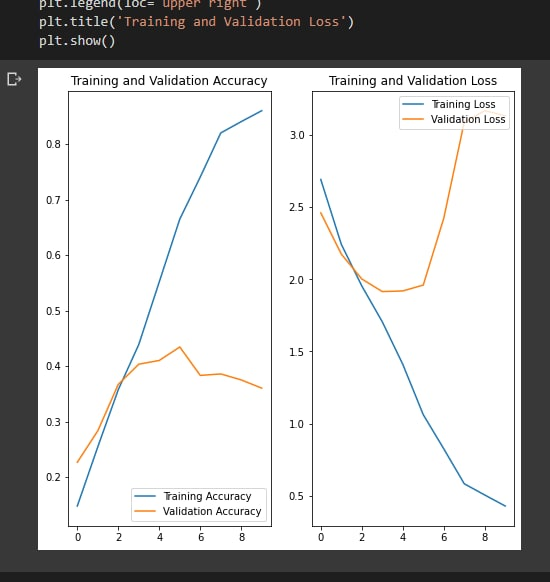

Bu örnekte unutma ve veri artırma işlemi uygulanmadan alınan sonuç gözükmektedir. Loss değerinden anlaşıldığı üzere overfitting gerçekleşmiştir.

##Örnek-3


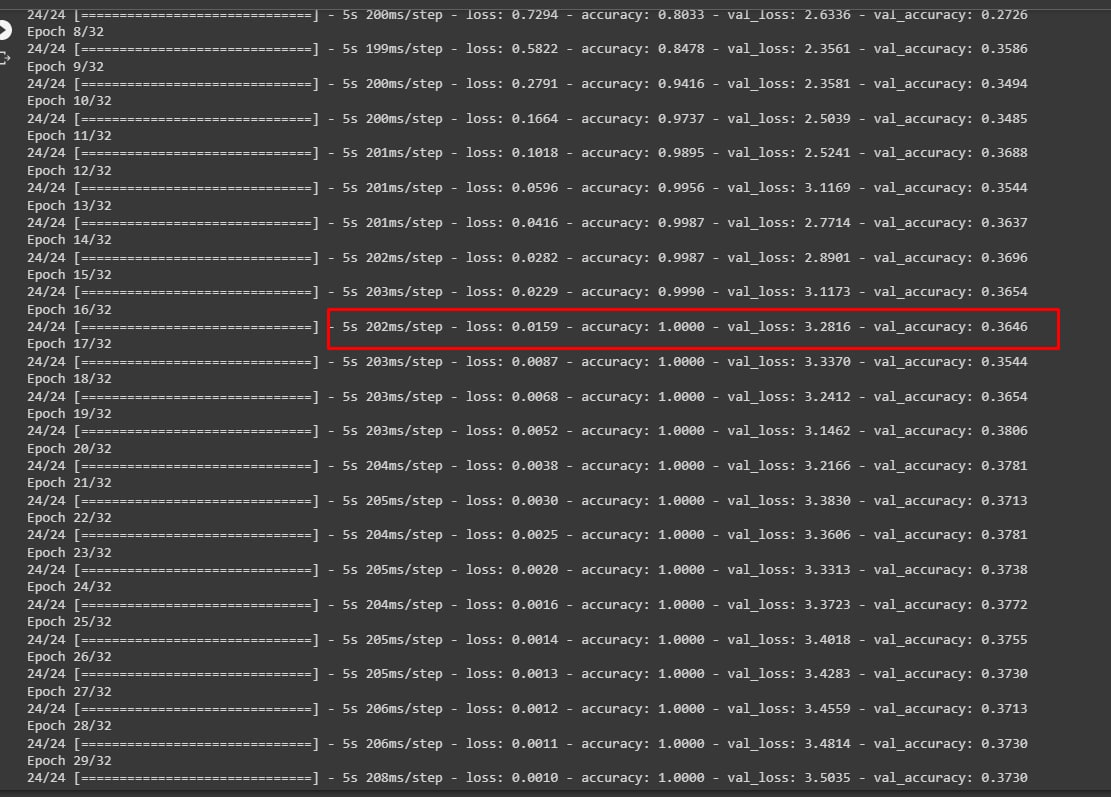

Overfitting örneği.




##Örnek-4
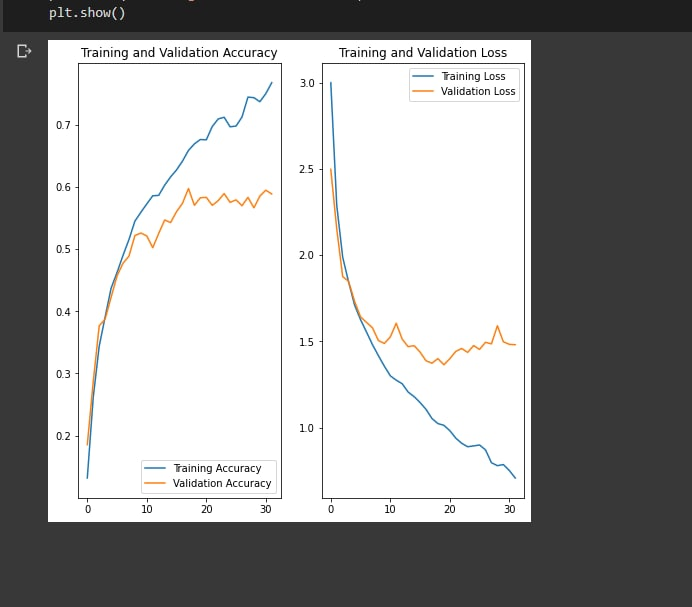

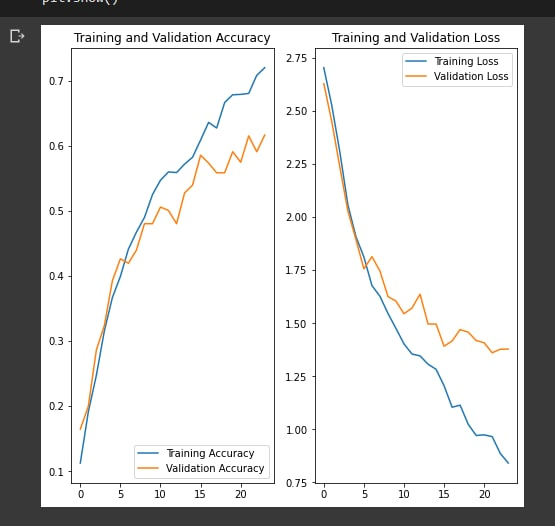

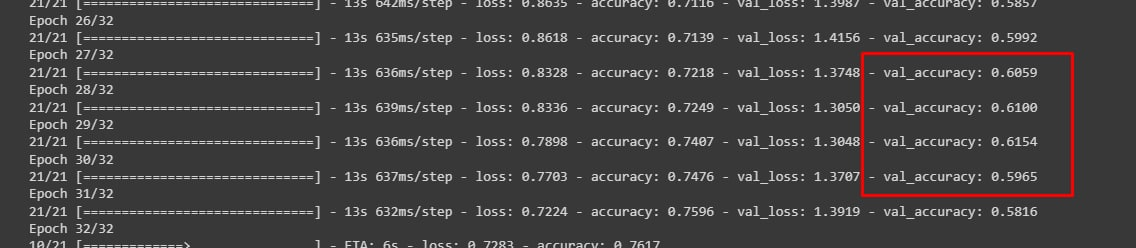

Elde edilen en iyi accuracy scorelar. Değerler --> 0.4 train 3 aşama sinir 0.2 valid 0.5 drop 128 batch


##Örnek-5
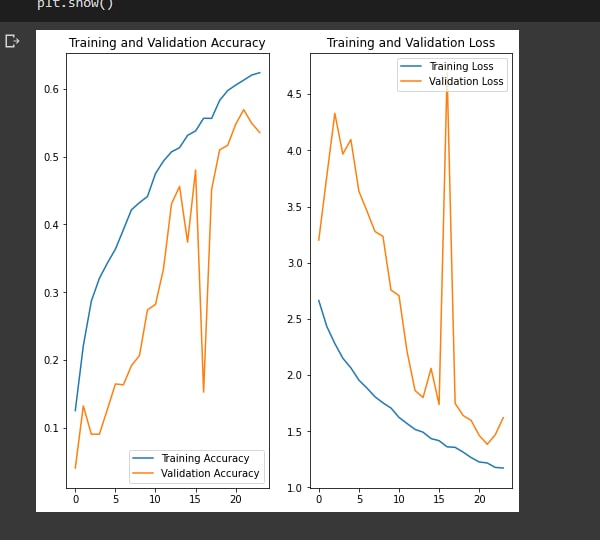

Sert iniş çıkışların yaşandığı bir örnek. BatchNormalization uygulandıktan sonra elde edilmiş bir grafiktir. Doğrulama seti büyük olasılıkla tüm veri setini temsil etmediğinden, doğrulama kaybı çok değişiyor. Doğrulama setini karıştırmayı/yeniden örneklemeyi veya daha büyük bir doğrulama fraksiyonu kullanımı tavsiye edilir.

##Örnek-6

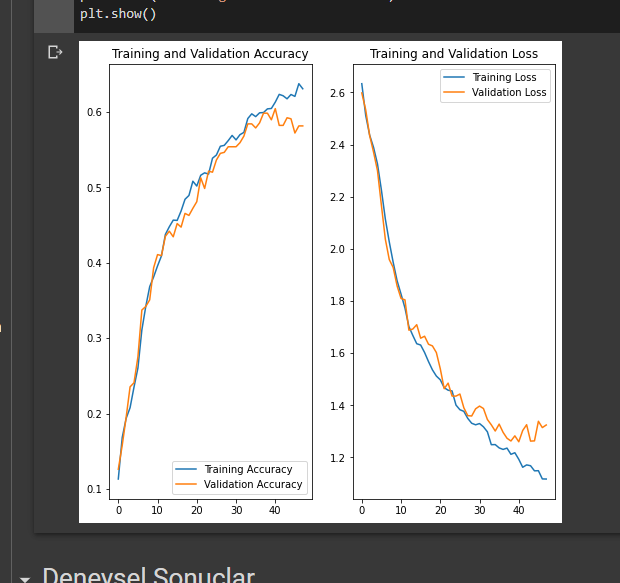

Aynı modele Batchnormalization uygulanmadığında alınan sonuç.

#Farklı Resimlerin Sınıflandırılması

In [ ]:
'''!ls'''

In [ ]:
'''root = ("/gdrive/My Drive/TurkSofrasi/")
image_path =  root + "adana-kebap.jpg"
test_image_original = image.load_img(image_path)

test_image = image.load_img(image_path, target_size=(128,128),grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

result = model.predict(test_data, batch_size=1)
result'''

In [ ]:
'''import tensorflow as tf
import cv2

IMAGE_CHANNEL = 3 # or 3

def prepare(filepath):
    IMG_SIZE = 112
    img_array = cv2.imread("/gdrive/My Drive/TurkSofrasi/adana-kebap.jpg", cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

x = tf.keras.Input(shape=(112,112,IMAGE_CHANNEL))
y = tf.keras.layers.Dense(16, activation='softmax')(x)
model = tf.keras.Model(x, y)
model.summary()


prediction = model.predict([prepare("test.jpg")])
print(prediction)'''

In [ ]:
'''probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])'''

In [ ]:
'''from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
 
from keras.models import load_model
 
model = load_model('model_saved.h5')
 
image = load_img('/gdrive/My Drive/TurkSofrasi/test_img/adana-kebap.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = model.predict(img)
print("Predicted Class: ", label)'''

In [ ]:
'''root = root = '/gdrive/My Drive/TurkSofrasi/'

model_best = load_model(root + '/model_saved.h5')'''

In [ ]:
'''os.chdir('/gdrive/My Drive/TurkSofrasi/')'''


In [ ]:
'''!ls'''


In [ ]:
'''from PIL import Image

img = Image.open('adana-kebap.jpg')

print(img.format)
print(img.size)
print(img.mode)'''

In [ ]:
'''# Add the image to a batch where it's the only member.
img2 = (np.expand_dims(img,0))

print(img2.shape)'''

In [ ]:
'''predictions_single = probability_model.predict(img2)

print(predictions_single)'''

In [ ]:
'''class_names = ['baklava', 'biber dolması', 'borek', 'cigkofte', 'enginar', 'hamsi', 'hunkar begendi', 'icli kofte', 'ispanak', 'kebap', 'kisir', 'kuru fasulye', 'lahmacun', 'lokum', 'mantı', 'simit', 'yaprak sarma']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.2  #bar genişliği


# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color = 'blue')

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(root + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()'''

In [ ]:
'''plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yemek Sınıfları",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()'''